In [2]:
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain.docstore.document import Document
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langgraph.types import Command
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import PromptTemplate
from typing import Literal

from typing import List, Optional
from typing_extensions import TypedDict


import cv2
import torch
import clip
from PIL import Image
import numpy as np
import pickle
import re

import json
import hashlib
import os

load_dotenv()

car_type = "EQS"
embedding = OpenAIEmbeddings(model="text-embedding-3-large") #text-embedding-ada-002, text-embedding-3-large

# CLIP 모델과 전처리 로딩 (예: RN50 사용하면 더 빠를 수 있음)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)
icon_folder = "./icons"
embeddings_path = "icon_embeddings.pkl"
IMAGE_PATTERN = r'((?:[A-Za-z]:/|https?://)\S+\.(?:png|jpg|jpeg|gif))'

In [3]:
class AgentState(TypedDict, total=False):
    messages: List[HumanMessage]  # 기존 대화 메시지 리스트
    image: Optional[str]          # 단일 이미지 URL (예: 선택된 이미지)
    # 필요에 따라 추가 정보를 위한 필드를 더 정의할 수 있습니다.

In [7]:
def imread_unicode(file_path):
    stream = np.fromfile(file_path, dtype=np.uint8)
    img = cv2.imdecode(stream, cv2.IMREAD_COLOR)
    return img

def resize_image(image, max_dim=800):
    height, width = image.shape[:2]
    if max(height, width) > max_dim:
        scaling_factor = max_dim / float(max(height, width))
        new_width = int(width * scaling_factor)
        new_height = int(height * scaling_factor)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        return resized_image
    return image

In [8]:
def retrieve_or_image_node(state: AgentState) -> Command[Literal["retrieve_search", "image_search"]]:
    # 첫 번째 메시지의 content를 가져옵니다.
    user_query = state["messages"][0].content
    
    # 이미지 URL(또는 로컬 경로)이 포함되어 있는지 검사
    match = re.search(IMAGE_PATTERN, user_query, flags=re.IGNORECASE)
    if match:
        image_url = match.group(0)  # 첫 번째 매칭된 이미지 URL 추출
        updated_query = re.sub(IMAGE_PATTERN, '', user_query, count=1, flags=re.IGNORECASE).strip()
        state["messages"][0].content = updated_query
        state["image"] = image_url

        return Command(update={'messages': state['messages'], 'image': state['image']}, goto="image_search")
    else:
        return Command(update={'messages': state['messages']}, goto="retrieve_search")

In [10]:
def image_search_node(state: AgentState) -> Command:
    target_image_path = state["image"]
    target_image = Image.open(target_image_path).convert("RGB")

    # 저장된 아이콘 이미지 임베딩 로딩 또는 계산 함수
    def compute_and_save_embeddings():
        embeddings = {}
        for filename in os.listdir(icon_folder):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue
            image_path = os.path.join(icon_folder, filename)
            # imread_unicode와 resize_image는 사용자의 이미지 전처리 함수라고 가정합니다.
            img_cv = imread_unicode(image_path)
            if img_cv is None:
                continue
            img_cv = resize_image(img_cv, max_dim=500)
            # 이미지 전처리 (PIL 이미지로 변환 후 CLIP 전처리)
            img_pil = Image.fromarray(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
            input_tensor = preprocess(img_pil).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model.encode_image(input_tensor)
            embedding /= embedding.norm(dim=-1, keepdim=True)
            embeddings[filename] = embedding.cpu()  # CPU로 이동하여 저장
        # 임베딩 저장 (pickle 사용)
        with open(embeddings_path, "wb") as f:
            pickle.dump(embeddings, f)
        
    def load_embeddings():
        if os.path.exists(embeddings_path):
            with open(embeddings_path, "rb") as f:
                embeddings = pickle.load(f)
            return embeddings
        else:
            return None

    # 저장된 임베딩이 없다면 계산하고 저장
    icon_embeddings = load_embeddings()
    if icon_embeddings is None:
        compute_and_save_embeddings()
        icon_embeddings = load_embeddings()

    # 타겟 이미지 전처리 및 임베딩 추출, 정규화
    target_input = preprocess(target_image).unsqueeze(0).to(device)
    with torch.no_grad():
        target_embedding = model.encode_image(target_input)
    target_embedding /= target_embedding.norm(dim=-1, keepdim=True)

    # 저장된 임베딩과 타겟 이미지 간의 유사도 계산
    results = []
    for filename, embedding in icon_embeddings.items():
        # 각 임베딩은 [1, D] 형태이므로 내적을 통해 코사인 유사도를 계산
        similarity = (target_embedding.cpu() @ embedding.T).item()
        results.append((filename, similarity))

    # 유사도 내림차순 정렬
    results.sort(key=lambda x: x[1], reverse=True)
    state["image"] = results[0][0]

    # state에 추가된 정보를 포함하여 업데이트된 state를 반환
    return Command(update=state)


In [11]:
pinecone_api_key = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)
index_name = "kcc"
# text-embedding-ada-002 모델의 임베딩 차원은 1536입니다.
if index_name not in [idx.name for idx in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
    )

# Pinecone 인덱스 로드
index = pc.Index(index_name)
database = PineconeVectorStore(index_name=index_name, embedding=embedding)


In [12]:
def get_file_hash(filename):
    """파일의 SHA-256 해시값을 계산합니다."""
    h = hashlib.sha256()
    with open(filename, 'rb') as f:
        h.update(f.read())
    return h.hexdigest()

def load_stored_hash(hash_file):
    """저장된 해시값을 읽어옵니다."""
    try:
        with open(hash_file, "r", encoding="utf-8") as f:
            return f.read().strip()
    except FileNotFoundError:
        return None

def save_hash(hash_file, hash_value):
    """해시값을 파일에 저장합니다."""
    with open(hash_file, "w", encoding="utf-8") as f:
        f.write(hash_value)

In [13]:
hash_file = "test.json.hash"
current_hash = get_file_hash("test.json")
stored_hash = load_stored_hash(hash_file)

if stored_hash != current_hash:
    json_file = "test.json"
    with open(json_file, "r", encoding="utf-8") as f:
        test_data = json.load(f)

    # Document 객체 리스트 생성
    documents = []

    for item in test_data:
        pdf_file = item.get("pdf_file", "")
        structure = item.get("structure", [])

        for i, section in enumerate(structure):
            title = section.get("title", "")
            sub_titles = section.get("sub_titles", [])
            content_text = title  # 섹션 텍스트 시작
            image_paths = []      # 이미지 경로 저장 리스트

            for sub in sub_titles:
                sub_title = sub.get("title", "")
                contents = sub.get("contents", [])

                # 이미지 경로 추출
                for content in contents:
                    if content.lower().endswith(('.jpeg', '.jpg', '.png', '.gif')):
                        image_paths.append(content)

                # 일반 텍스트 내용 결합 (이미지 경로 제외)
                non_image_contents = [c for c in contents if not c.lower().endswith(('.jpeg', '.jpg', '.png', '.gif'))]
                content_text += "\n" + sub_title + "\n" + "\n".join(non_image_contents)

            # Document 객체 생성
            metadata = {
                "pdf_file": pdf_file,
                "section_title": title,
                "image_paths": json.dumps(image_paths)  # 리스트를 문자열로 변환
            }
            documents.append(Document(page_content=content_text, metadata=metadata))
    # Pinecone 벡터 스토어에 데이터 추가
    database.add_documents(documents)

In [14]:
llm = ChatOpenAI(model='gpt-4o')

In [15]:
retriever = database.as_retriever(search_kwargs={"k": 3})

In [16]:
@tool
def vector_retrieve_tool(query: str) -> List[Document]:
    """Retrieve documents based on the given query."""
    return retriever.invoke(query)

def dynamic_state_modifier(agent_input: AgentState) -> str:
    image_val = agent_input.get("image", "no_image")

    return (
        f"You are an expert on Mercedes Benz {car_type} car manuals. "
        f"The Topic of the provided target image is {image_val}. "
        "Please consider the information you provided and reply with facts (not opinions). "
        "Translate the answer into Korean and format each item on a separate line. "
        "## {{제목}}\n"
        "Example: Mercedes Benz EQS: Driver Display Charge Status Window Function\n\n"
        "### {{주요 정보}}\n"
        "- Feature Summary and Key Points\n\n"
        "### {{상세 설명}}\n"
        "- Detailed description of features\n\n"
    )


def retrieve_search_node(state: AgentState) -> Command:
    retrieve_search_agent = create_react_agent(
        llm,
        tools=[vector_retrieve_tool],
        state_modifier=dynamic_state_modifier(state)  # 함수로 교체
    )
    result = retrieve_search_agent.invoke(state)
    # 내부 retrieval 결과를 상태에 저장
    state["retrieve_result"] = result['messages'][-1].content
    
    # 사용자 쿼리를 state에서 추출 (첫 번째 메시지가 HumanMessage라고 가정)
    user_query = state["messages"][0].content
    # retriever를 직접 호출하여 Document 리스트를 가져옴
    docs = retriever.invoke(user_query)
    
    displayed_image = None
    for doc in docs:
        meta = doc.metadata
        if "image_paths" in meta and meta["image_paths"]:
            try:
                # image_paths는 json.dumps로 저장되어 있으므로 디코딩
                image_paths = json.loads(meta["image_paths"])
            except Exception:
                image_paths = meta["image_paths"]
            if isinstance(image_paths, list) and len(image_paths) > 0:
                displayed_image = image_paths[0]
                break
    # retrieval 결과 앞에 이미지 링크(존재할 경우) 추가
    state["retrieve_result"] = (displayed_image or "") + '\n\n' + state["retrieve_result"] + "\n"
    
    # 기존 messages 리스트에 retrieval 결과를 추가
    state.setdefault("messages", []).append(
        HumanMessage(content=state["retrieve_result"], name="retrieve_search")
    )
    # 전체 messages 리스트를 업데이트
    return Command(update={'messages': state["messages"]})


In [17]:
def evaluate_node(state: AgentState) -> Command[Literal['web_search', END]]:
    retrieve_result = state.get("retrieve_result", "").strip()

    if retrieve_result == "":
        print("검색 결과가 없습니다. 웹 검색을 시도합니다.")
        return Command(goto='web_search')

    # retrieval 결과가 충분할 수 있으므로 LLM 평가 프롬프트 실행
    eval_prompt = PromptTemplate.from_template(
        "You are an expert on Mercedes Benz " + car_type + " car manuals."
        "Please rate if the retrive results below provide sufficient answers."
        "You must assess that the answers or answers of more than 200 characters are sufficiently consistent with your question."
        "If you don't have enough information to judge, or if you don't provide it in your answer, answer 'yes', and answer no if enough is enough.\n\n"
        "Retrieve Results:\n{result}"
    )
    eval_chain = eval_prompt | llm
    evaluation = eval_chain.invoke({"result": state.get("retrieve_result")})
    if "yes" in evaluation.content.lower():
          print("답변이 충분하지 않습니다. 웹 검색을 시도합니다.")
          return Command(goto='web_search')
    else:
          return Command(goto=END)


In [ ]:
tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

web_search_agent = create_react_agent(
    llm, 
    tools=[tavily_search_tool],
    state_modifier = (
        "You are an expert on Mercedes Benz " + car_type + " car manuals."
        "Please reply to the website information in detail. Please translate the answer into Korean and print it out."
        "Please refer to the structure below to organize the website information:\n\n"
        "## {{제목}}\n"
        "Example: Mercedes Benz EQS: Driver Display Charge Status Window Function\n\n"
        "### {{주요 정보}}\n"
        "- Feature Summary and Key Points\n\n"
        "### {{상세 설명}}\n"
        "- Detailed description of the feature. / {{source}}: website link\n\n"
        "Please translate the answer into Korean, separate each item into separate lines and print it out in a good way."
    )
)

def web_search_node(state: AgentState) -> Command:
    result = web_search_agent.invoke(state)
    state["web_result"] = result['messages'][-1].content
    state.setdefault("messages", []).append(
        HumanMessage(content=state["web_result"], name="web_se  arch")
    )
    return Command(update={'messages': state["messages"]})


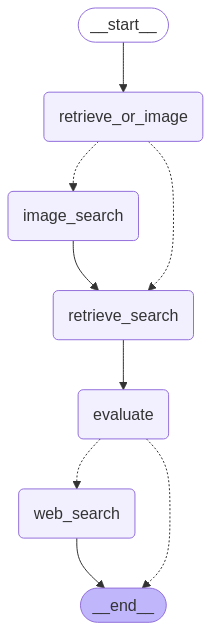

In [19]:
# 그래프 구성 (evaluate 노드에서 조건에 따라 goto가 web_search로 갈 수 있도록)
graph_builder = StateGraph(AgentState)
graph_builder.add_node("retrieve_search", retrieve_search_node)
graph_builder.add_node("evaluate", evaluate_node)
graph_builder.add_node("web_search", web_search_node)
graph_builder.add_node("image_search", image_search_node)
graph_builder.add_node("retrieve_or_image", retrieve_or_image_node)

graph_builder.add_edge(START, "retrieve_or_image")
graph_builder.add_edge("image_search", "retrieve_search")   
graph_builder.add_edge("retrieve_search", "evaluate")
graph_builder.add_edge("web_search", END)

graph = graph_builder.compile()
graph

In [21]:
query = """C/inflearn-rag-notebook-main/test.jpeg
계기판에 이거 떴는데 뭐야?
"""
for chunk in graph.stream(
    {"messages": [HumanMessage(content=query, name="user")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================
Name: user

C/inflearn-rag-notebook-main/test.jpeg
계기판에 이거 떴는데 뭐야?

================================ Human Message =================================
Name: user

C/inflearn-rag-notebook-main/test.jpeg
계기판에 이거 떴는데 뭐야?

================================ Human Message =================================
Name: retrieve_search



제공된 이미지가 없어서 Mercedes Benz EQS 차량의 일반적인 계기판 경고등 또는 표시와 관련된 정보를 드릴 수 있습니다. 차량 계기판에 표시되는 경고등이나 메시지는 차량의 상태를 알리는 중요한 역할을 하며, 다양한 종류가 있습니다. 각 경고등의 의미와 대처 방법에 대해 설명드리겠습니다.

### 일반적인 Mercedes Benz EQS 계기판 경고등과 표시

- **배터리 충전 상태**: 배터리의 충전 상태를 나타내며, 충전 필요 여부를 알려줍니다.
- **브레이크 경고**: 브레이크 시스템에 문제가 생겼음을 알리는 경고등입니다.
- **전기 시스템 경고**: 전기 시스템에 이상이 있을 때 표시됩니다.
- **엔진 경고등**: 엔진 관련 문제 발생 시 켜집니다.
- **타이어 압력 경고**: 타이어의 압력이 적정 수준보다 낮을 때 알려줍니다.

### 경고등의 대처 방법

1. **차량 매뉴얼 확인**: 차량 매뉴얼에는 각각의 경고등과 그에 대한 설명 및 대처 방법이 자세히 나와 있습니다.
2. **즉각적인 점검**: 중요 경고등이 켜질 경우 즉시 차량을 점검해야 하며, 필요시 서비스 센터를 방문해야 합니다.
3. **전문가 상담**: 경고